In [44]:
import sys
import os
import cv2
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy as np
import tensorflow as tf

In [45]:
file_names = glob.glob('site_images_traffic_only\\*.jpg')

In [46]:
def tl_light_classifier(image):
    width_to_trim = int(image.shape[1] / 3)
    # height_to_trim = int(image.shape[0] / 10)
    height_to_trim = 0
    sub_image = image[height_to_trim:(image.shape[0]-height_to_trim), width_to_trim:(image.shape[1]-width_to_trim)]
    
    G_threshold = (200, 255)
    R_threshold = (200, 255)
    B_threshold = (200, 255)
    
    R = tl_image[:,:,0]
    G = tl_image[:,:,1]
    B = tl_image[:,:,2]
    
    B_binary = np.zeros_like(B)
    B_binary[(B > B_threshold[0]) & (B <= B_threshold[1])] = 1
    
    G_binary = np.zeros_like(G)
    G_binary[(G > G_threshold[0]) & (G <= G_threshold[1])] = 1
    
    R_binary = np.zeros_like(R)
    R_binary[(R > R_threshold[0]) & (R <= R_threshold[1])] = 1
    
    isRed = (np.sum(R_binary) / R_binary.size) > 0.05
    isGreen = (np.sum(G_binary) / G_binary.size) > 0.05
    isBlue = (np.sum(B_binary) / B_binary.size) > 0.05
    
    if isRed and isGreen and isBlue:
        return (0,255,0)
    elif isRed and isGreen:
        return (255,255,0)
    elif isRed:
        return (255,0,0)
    elif isGreen:
        return (0,255,0)
    else:
        return (255,255,255)

In [47]:
# MODEL_NAME = '..\\ssd_mobilenet_v1_coco_2017_11_17'
MODEL_NAME = '..\\faster_rcnn_inception_v2_coco_2017_11_08'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '\\frozen_inference_graph.pb'

# Load a (frozen) Tensorflow model into memory
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

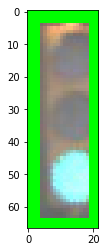

In [48]:
image = cv2.imread(file_names[4])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image, axis=0)

with detection_graph.as_default():
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

boxes = np.squeeze(boxes)
classes = np.squeeze(classes).astype(np.int32)
scores = np.squeeze(scores)

for idx, val in enumerate(classes):
    if val == 10:
        break

if scores[idx] >= 0.01:
    nbox = boxes[idx]

    height = image.shape[0]
    width = image.shape[1]

    box = np.array([nbox[0]*height, nbox[1]*width, nbox[2]*height, nbox[3]*width]).astype(int)
    tl_image = image[box[0]:box[2], box[1]:box[3]]
    
    colour = tl_light_classifier(tl_image)
    
    cv2.rectangle(image, (box[1],box[0]), (box[3],box[2]), colour, 5)
    
    plt.figure
    plt.imshow(tl_image)
    plt.show()

In [49]:
out_dir = 'site_traffic_light_images_out\\'

for filename in file_names:
    head, tail = os.path.split(filename)
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image, axis=0)

    with detection_graph.as_default():
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})

    boxes = np.squeeze(boxes)
    classes = np.squeeze(classes).astype(np.int32)
    scores = np.squeeze(scores)

    for idx, val in enumerate(classes):
        if val == 10:
            break

    if scores[idx] >= 0.1:
        nbox = boxes[idx]

        height = image.shape[0]
        width = image.shape[1]

        box = np.array([nbox[0]*height, nbox[1]*width, nbox[2]*height, nbox[3]*width]).astype(int)
        tl_image = image[box[0]:box[2], box[1]:box[3]]

        colour = tl_light_classifier(tl_image)
        
        cv2.rectangle(image, (box[1],box[0]), (box[3],box[2]), colour, 5)
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(out_dir + tail, image)

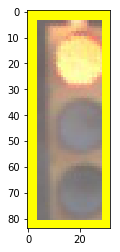

In [53]:
image = cv2.imread('site_images_traffic_only\\left0458.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image, axis=0)

with detection_graph.as_default():
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

boxes = np.squeeze(boxes)
classes = np.squeeze(classes).astype(np.int32)
scores = np.squeeze(scores)

for idx, val in enumerate(classes):
    if val == 10:
        break

if scores[idx] >= 0.01:
    nbox = boxes[idx]

    height = image.shape[0]
    width = image.shape[1]

    box = np.array([nbox[0]*height, nbox[1]*width, nbox[2]*height, nbox[3]*width]).astype(int)
    tl_image = image[box[0]:box[2], box[1]:box[3]]
    
    colour = tl_light_classifier(tl_image)
    
    cv2.rectangle(image, (box[1],box[0]), (box[3],box[2]), colour, 5)
    
    plt.figure
    plt.imshow(tl_image)
    plt.show()

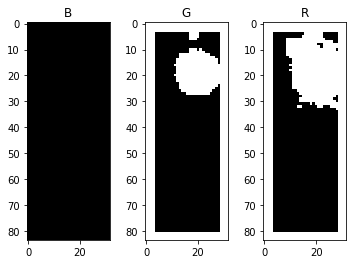

0.458705357143
0.3828125


In [54]:
plt.figure()

G_threshold = (200, 255)
R_threshold = (200, 255)
B_threshold = (200, 255)

idx = 0
R = tl_image[:,:,0]
G = tl_image[:,:,1]
B = tl_image[:,:,2]

plt.subplot(1, 3, 1)
B_binary = np.zeros_like(B)
B_binary[(B > B_threshold[0]) & (B <= B_threshold[1])] = 1
plt.imshow(B_binary, cmap='gray')
if (idx == 0):
    plt.title("B")

plt.subplot(1, 3, 2)
G_binary = np.zeros_like(G)
G_binary[(G > G_threshold[0]) & (G <= G_threshold[1])] = 1
plt.imshow(G_binary, cmap='gray')
if (idx == 0):
    plt.title("G")

plt.subplot(1, 3, 3)
R_binary = np.zeros_like(G)
R_binary[(R > R_threshold[0]) & (R <= R_threshold[1])] = 1
plt.imshow(R_binary, cmap='gray')
if (idx == 0):
    plt.title("R")
    
plt.show()

isRed = (np.sum(R_binary) / R_binary.size) > 0.05
isGreen = (np.sum(G_binary) / G_binary.size) > 0.05
isBlue = (np.sum(B_binary) / B_binary.size) > 0.05

print((np.sum(R_binary) / R_binary.size))
print((np.sum(G_binary) / G_binary.size))